In [111]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

##分解(decomposing) 可以用来把时序数据中的趋势和周期性数据都分离出来:
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [112]:
Data = pd.read_csv('./world.csv', index_col=0)#1月20日-3月18日 世界总确诊人数
#增加id递增列
Data = Data.reset_index()
##该步骤很重要！！建立时序数据
#Parse strings to datetime type  将字符串解析为datetime类型
#convert from string to datetime ###Name: date, dtype: datetime64[ns]
Data['日期']= pd.to_datetime(Data['日期'],infer_datetime_format=True) 
#set_index( ) 将 DataFrame 中的列转化为行索引
indexedDataset = Data.set_index(['日期'])
#数据反转
indexedDataset = indexedDataset.iloc[::-1]
indexedDataset


,confirmedCount
日期,
2020-01-20,282
2020-01-21,314
2020-01-22,581
2020-01-23,844
2020-01-24,1312
2020-01-25,2015
2020-01-26,2801
2020-01-27,4579
2020-01-28,6061


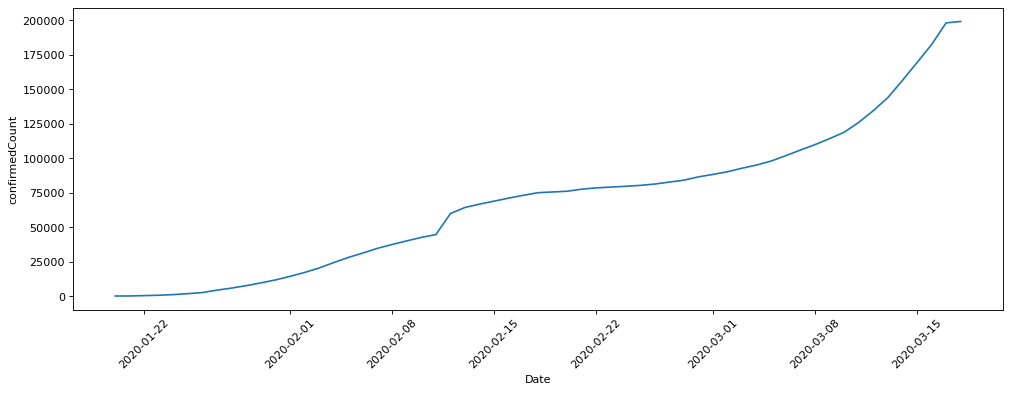

In [113]:
# plot graph
#设置画布大小
plt.figure(figsize=(15,5),dpi = 80)
#横轴坐标旋转45°
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('confirmedCount')
plt.plot(indexedDataset)

### 三、时序数据变换，获得稳定性数据  

#### 3.1构建稳定性检验函数：  
    #滑动平均值  
    #滑动标准差  
    #Augmented Dickey–Fuller ADF稳定性检验

In [114]:
#构建稳定性检验函数，一般pvalue值小于0.05，越小越好
def test_stationarity(timeseries):  
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()  #滑动平均值
    movingSTD = timeseries.rolling(window=12).std()     #滑动标准差
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:   Augmented Dickey–Fuller ADF稳定性检验
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['confirmedCount'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#### 3.2  Differencing差分方法-Timeshift transformation

(array([18283., 18293., 18300., 18307., 18314., 18322., 18329., 18336.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

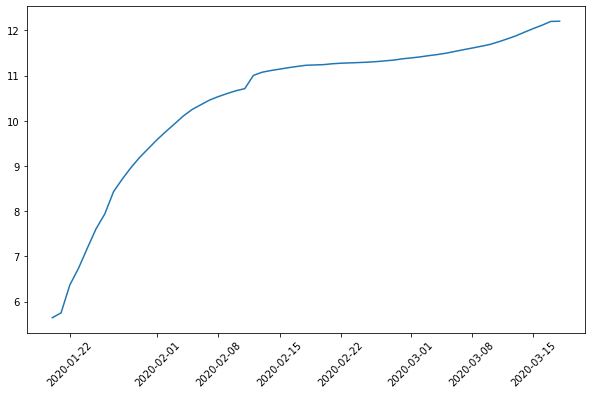

In [6]:
#Estimating trend 估计趋势
indexedDataset_logScale = np.log(indexedDataset)  #taking log 
plt.plot(indexedDataset_logScale)
plt.xticks(rotation=45)

(array([18283., 18293., 18300., 18307., 18314., 18322., 18329., 18336.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

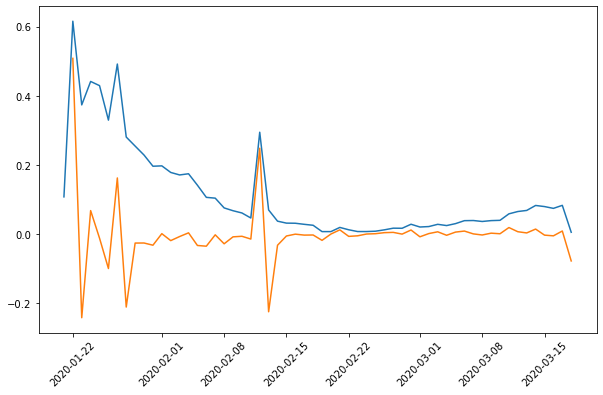

In [7]:
##Differencing--差分
##这里采用的是一阶差分：一阶差分就是离散函数中连续相邻两项之差。
datasetLogDiffShifting_1 = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting_1)

#二阶差分：二阶差分就是一阶差分再进行一次差分。
#注：以下内容可以看出，二阶差分后数据已经稳定，所以ARIMA模型参数d=2。
datasetLogDiffShifting_2 = datasetLogDiffShifting_1 - datasetLogDiffShifting_1.shift()
plt.plot(datasetLogDiffShifting_2)
plt.xticks(rotation=45)

(array([18283., 18293., 18300., 18307., 18314., 18322., 18329., 18336.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

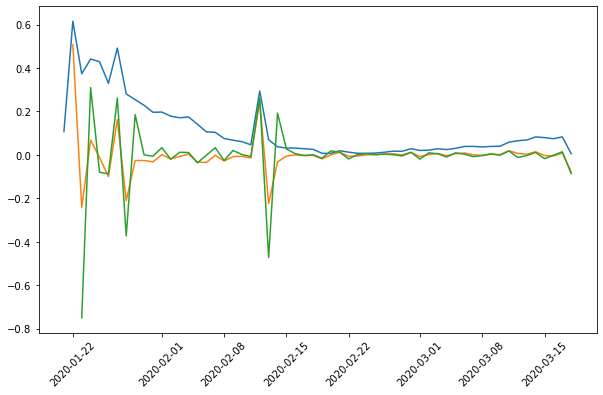

In [8]:
example1 = indexedDataset_logScale.diff(1)
plt.plot(example1)
example2 = example1.diff(1)
plt.plot(example2)
example3 = example2.diff(1)
plt.plot(example3)
plt.xticks(rotation=45)

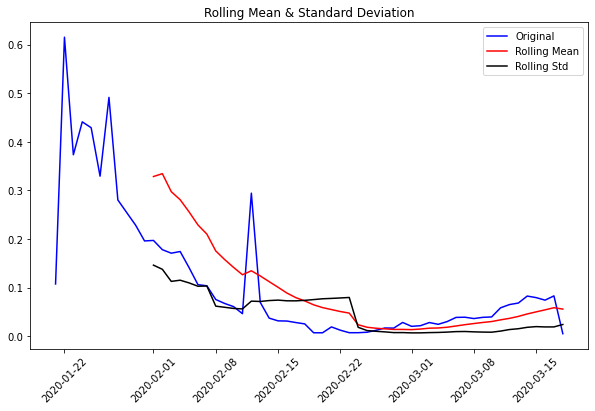

Results of Dickey Fuller Test:
Test Statistic                 -2.847150
p-value                         0.051848
#Lags Used                      2.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


In [61]:
datasetLogDiffShifting_1.dropna(inplace=True)#滤除缺失数据。
test_stationarity(datasetLogDiffShifting_1)

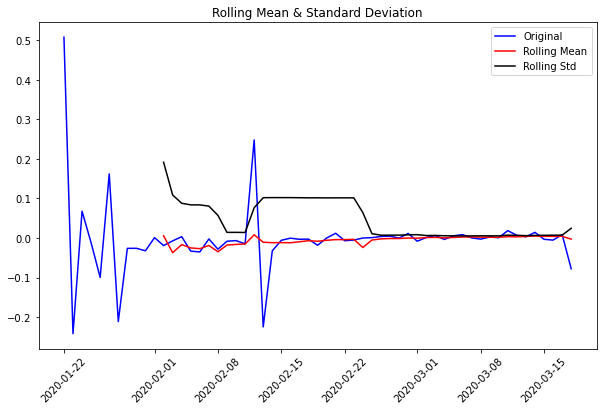

Results of Dickey Fuller Test:
Test Statistic                -8.336685e+00
p-value                        3.258054e-13
#Lags Used                     1.000000e+00
Number of Observations Used    5.500000e+01
Critical Value (1%)           -3.555273e+00
Critical Value (5%)           -2.915731e+00
Critical Value (10%)          -2.595670e+00
dtype: float64


In [60]:
datasetLogDiffShifting_2.dropna(inplace=True)#滤除缺失数据。
test_stationarity(datasetLogDiffShifting_2)

差分后平稳性都要比原数据好很多。

### 四、构建模型
#### 4.1 自相关图和偏自相关图的分析

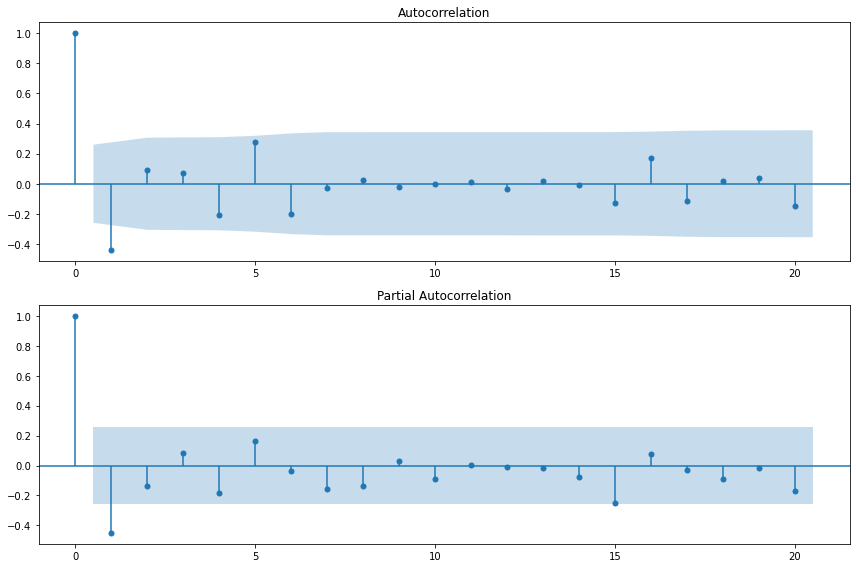

In [115]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))

#acf   from statsmodels.tsa.stattools import acf, pacf
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasetLogDiffShifting_2, lags=20,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout();

#pacf
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasetLogDiffShifting_2, lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout();
#下图中的阴影表示置信区间，可以看出不同阶数自相关性的变化情况，从而选出p值和q值

In [119]:
import warnings
warnings.filterwarnings("ignore")

#遍历，寻找适宜的参数
import itertools
 
p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4
 
# Initialize a DataFrame to store the results,，以BIC准则
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
 
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
 
    try:
        model = sm.tsa.ARIMA(datasetLogDiffShifting_2, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

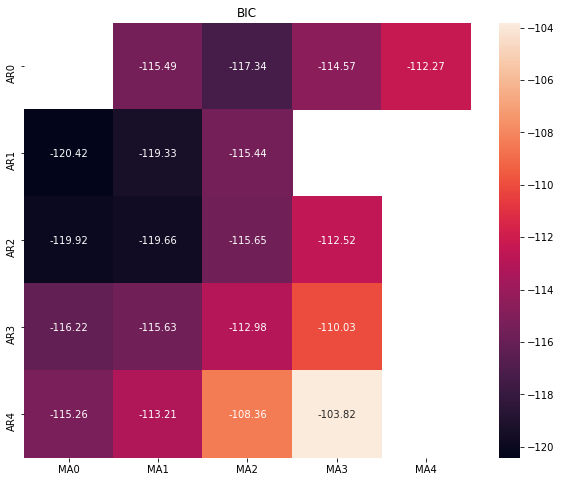

In [120]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 )
ax.set_title('BIC')
plt.show()

p=3/4  q=3

#### 建立模型

Plotting ARIMA model


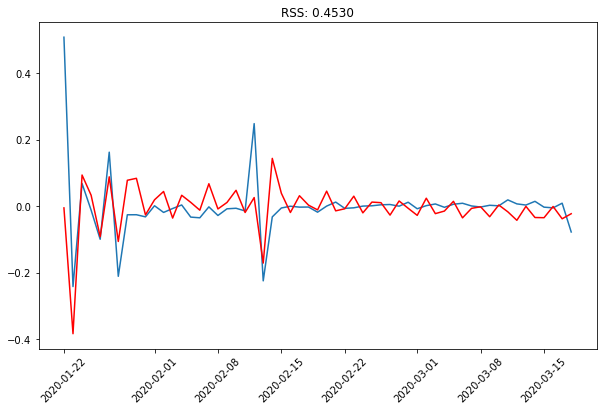

In [121]:
# AR+I+MA = ARIMA model
"""
ARIMA模型有三个参数:p,d,q。
p--代表预测模型中采用的时序数据本身的滞后数(lags) ,也叫做AR/Auto-Regressive项
d--代表时序数据需要进行几阶差分化，才是稳定的，也叫Integrated项。
q--代表预测模型中采用的预测误差的滞后数(lags)，也叫做MA/Moving Average项

"""
import warnings
warnings.filterwarnings('ignore')
model_3 = ARIMA(indexedDataset_logScale, order=(4,2,3))
results_ARIMA = model_3.fit(disp=-1)
plt.plot(datasetLogDiffShifting_2)
plt.plot(results_ARIMA.fittedvalues, color='red')#模型数据的差分值
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting_2['confirmedCount'])**2))
plt.xticks(rotation=45)
print('Plotting ARIMA model')

In [109]:
import seaborn as sns

#### 五、时序数据预测

In [122]:
#ARIMA拟合的其实是一阶差分ts_log_diff，predictions_ARIMA_diff[i]是第i个天与i-1个天的ts_log的差值。
#由于差分化有一阶滞后，所以第一个天的数据是空的
predictions_ARIMA_diff_2 = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_2#ARIMA拟合的一阶差分值

日期
2020-01-22   -0.005440
2020-01-23   -0.383718
2020-01-24    0.093466
2020-01-25    0.032752
2020-01-26   -0.091983
2020-01-27    0.088005
2020-01-28   -0.106318
2020-01-29    0.077671
2020-01-30    0.083583
2020-01-31   -0.026358
2020-02-01    0.018949
2020-02-02    0.043983
2020-02-03   -0.035968
2020-02-04    0.032567
2020-02-05    0.011220
2020-02-06   -0.012280
2020-02-07    0.067269
2020-02-08   -0.008560
2020-02-09    0.010960
2020-02-10    0.047566
2020-02-11   -0.019182
2020-02-12    0.025685
2020-02-13   -0.171280
2020-02-14    0.143519
2020-02-15    0.038690
2020-02-16   -0.019146
2020-02-17    0.031184
2020-02-18    0.002865
2020-02-19   -0.011343
2020-02-20    0.044959
2020-02-21   -0.014241
2020-02-22   -0.008011
2020-02-23    0.029876
2020-02-24   -0.020310
2020-02-25    0.012084
2020-02-26    0.010329
2020-02-27   -0.027058
2020-02-28    0.015403
2020-02-29   -0.006511
2020-03-01   -0.027832
2020-03-02    0.023749
2020-03-03   -0.022632
2020-03-04   -0.014944
2020-03-

In [100]:
indexedDataset_logScale

,confirmedCount
日期,
2020-01-20,5.641907
2020-01-21,5.749393
2020-01-22,6.364751
2020-01-23,6.738152
2020-01-24,7.179308
2020-01-25,7.608374
2020-01-26,7.937732
2020-01-27,8.429236
2020-01-28,8.709630


In [123]:
#Convert to cumulative sum 累计和
#累加现有的diff，得到每个值与第一个天的差分（同log底的情况下）。
#即predictions_ARIMA_diff_cumsum[i] 是第i个月与第1个月的ts_log的差值。
predictions_ARIMA_diff_cumsum_2 = predictions_ARIMA_diff_2.cumsum()

print(predictions_ARIMA_diff_cumsum_2)

日期
2020-01-22   -0.005440
2020-01-23   -0.389158
2020-01-24   -0.295691
2020-01-25   -0.262939
2020-01-26   -0.354921
2020-01-27   -0.266916
2020-01-28   -0.373234
2020-01-29   -0.295563
2020-01-30   -0.211980
2020-01-31   -0.238338
2020-02-01   -0.219388
2020-02-02   -0.175405
2020-02-03   -0.211373
2020-02-04   -0.178806
2020-02-05   -0.167586
2020-02-06   -0.179866
2020-02-07   -0.112597
2020-02-08   -0.121157
2020-02-09   -0.110198
2020-02-10   -0.062632
2020-02-11   -0.081814
2020-02-12   -0.056129
2020-02-13   -0.227409
2020-02-14   -0.083890
2020-02-15   -0.045201
2020-02-16   -0.064346
2020-02-17   -0.033162
2020-02-18   -0.030297
2020-02-19   -0.041640
2020-02-20    0.003319
2020-02-21   -0.010922
2020-02-22   -0.018933
2020-02-23    0.010943
2020-02-24   -0.009367
2020-02-25    0.002717
2020-02-26    0.013046
2020-02-27   -0.014012
2020-02-28    0.001390
2020-02-29   -0.005121
2020-03-01   -0.032953
2020-03-02   -0.009205
2020-03-03   -0.031836
2020-03-04   -0.046780
2020-03-

In [102]:
#predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff_cumsum.cumsum()

In [131]:
#先ts_log_diff => ts_log=>ts_log => ts 
#先以ts_log的第一个值作为基数，复制给所有值，然后每个时刻的值累加与第一个月对应的差值(这样就解决了，第1、2个天diff数据为空的问题了)
#然后得到了predictions_ARIMA_log => predictions_ARIMA
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['confirmedCount'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log_1 = predictions_ARIMA_log.add(datasetLogDiffShifting_1['confirmedCount'].iloc[0])
predictions_ARIMA = predictions_ARIMA_log_1.add(predictions_ARIMA_diff_cumsum_2, fill_value=0)

predictions_ARIMA.head()

日期
2020-01-20    5.749393
2020-01-21    5.749393
2020-01-22    5.743953
2020-01-23    5.360235
2020-01-24    5.453702
dtype: float64

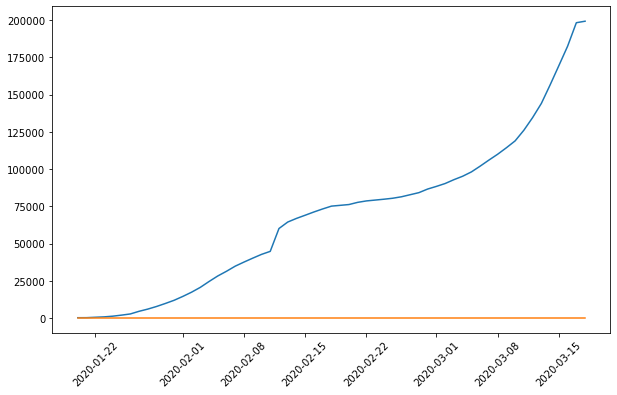

In [127]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
#predictions_ARIMA

plt.xticks(rotation=45)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

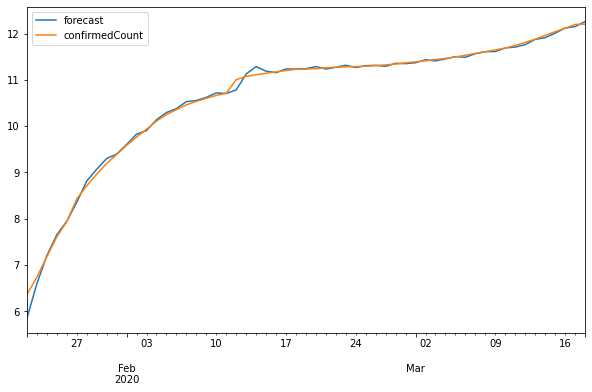

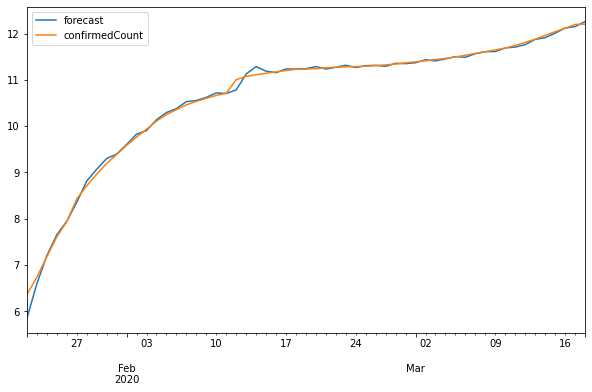

In [132]:
#We have 144(existing data of 12 yrs in months) data points. 
#And we want to forecast for additional 120 data points or 10 yrs.
results_ARIMA.plot_predict() 

# predictions_ARIMA_=results_ARIMA.predict(1,68)#取68天的预测结果


predictions_ARIMA_diff = pd.Series(predictions_ARIMA_, copy=True)
predictions_ARIMA_diff#ARIMA拟合的一阶差分值
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()


#先ts_log_diff => ts_log=>ts_log => ts 
#先以ts_log的第一个值作为基数，复制给所有值，然后每个时刻的值累加与第一个月对应的差值(这样就解决了，第1、2个天diff数据为空的问题了)
#然后得到了predictions_ARIMA_log => predictions_ARIMA
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['confirmedCount'].iloc[0], index=predictions_ARIMA_.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
print(predictions_ARIMA)


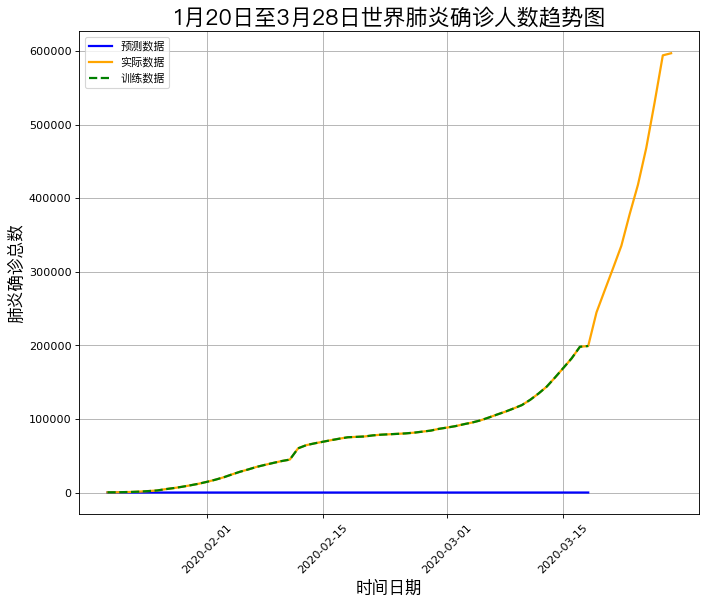

In [134]:
Data1 = pd.read_csv('./world0120-0328.csv', index_col=0)#1月20日-3月28日 世界总确诊人数
#增加id递增列
#增加id递增列

Data1 = Data1.reset_index()
Data1['日期']= pd.to_datetime(Data1['日期'],infer_datetime_format=True) 
#set_index( ) 将 DataFrame 中的列转化为行索引
indexedDataset_original = Data1.set_index(['日期'])

#数据反转
indexedDataset_original = indexedDataset_original.iloc[::-1]



from matplotlib import font_manager

# my_font = font_manager.FontProperties(fname="C:/Windows/Fonts/simhei.ttf") #windows黑体
my_font = font_manager.FontProperties(fname="/System/Library/Fonts/PingFang.ttc")
plt.figure(figsize=(10,8),dpi = 80)
plt.xticks(rotation=45,fontsize=10)
plt.yticks(fontsize=10)

plt.plot(predictions_ARIMA,markersize=30,label='预测数据',color = 'blue',linewidth=2.0)#1月20日-3月28日 世界总确诊人数预测曲线
plt.plot(indexedDataset_original,markersize=30,label='实际数据',color = 'orange',linewidth=2.0)#1月20日-3月28日 世界总确诊人数实际曲线
plt.plot(indexedDataset,markersize=30,label='训练数据',color = 'green',linestyle='--',linewidth=2.0)#1月20日-3月18日 世界总确诊人数训练集曲线

##添加描述信息
plt.xlabel("时间日期",fontproperties = my_font,fontsize=15)
plt.ylabel("肺炎确诊总数",fontproperties = my_font,fontsize=15)
plt.title("1月20日至3月28日世界肺炎确诊人数趋势图",fontproperties = my_font,fontsize=20)
plt.grid(alpha=1) #网格线的透明程度  数值越大，网格颜色越深
## 添加图例
#############################待解决问题：为何我的图例 不会变大！！！！############################
plt.legend(prop = my_font,loc="upper left")
#plt.savefig('figure.eps')
plt.show()

In [83]:
results_ARIMA.fittedvalues

日期
2020-01-21    0.155782
2020-01-22    0.122466
2020-01-23    0.207145
2020-01-24    0.445540
2020-01-25    0.469813
2020-01-26    0.346324
2020-01-27    0.467502
2020-01-28    0.289589
2020-01-29    0.471519
2020-01-30    0.275305
2020-01-31    0.265749
2020-02-01    0.202876
2020-02-02    0.214951
2020-02-03    0.173614
2020-02-04    0.195796
2020-02-05    0.153820
2020-02-06    0.184587
2020-02-07    0.129208
2020-02-08    0.126112
2020-02-09    0.089335
2020-02-10    0.097103
2020-02-11    0.058521
2020-02-12    0.079056
2020-02-13    0.071111
2020-02-14    0.228023
2020-02-15    0.121475
2020-02-16    0.025699
2020-02-17    0.054713
2020-02-18    0.020913
2020-02-19    0.052874
2020-02-20    0.015306
2020-02-21    0.035050
2020-02-22    0.000843
2020-02-23    0.040551
2020-02-24    0.007357
2020-02-25    0.031184
2020-02-26    0.002484
2020-02-27    0.031212
2020-02-28    0.007849
2020-02-29    0.037950
2020-03-01    0.014568
2020-03-02    0.045396
2020-03-03    0.019500
2020-03-

In [84]:
results_ARIMA.predict(1,69)

2020-01-21    0.155782
2020-01-22    0.122466
2020-01-23    0.207145
2020-01-24    0.445540
2020-01-25    0.469813
                ...   
2020-03-25    0.039158
2020-03-26    0.089280
2020-03-27    0.053993
2020-03-28    0.084269
2020-03-29    0.070034
Freq: D, Length: 69, dtype: float64